# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes 

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation. 

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`. 

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call. 

Let's create a list of messages. 

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author 
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content="So you do reverse engineering ?",name="Modle")]
messages.append(HumanMessage(content="Yes, I do reverse engineering alot", name="hijazi"))
messages.append(AIMessage(content="Nice, What do you want to learn?",name="Model"))
messages.append(HumanMessage(content="I want to learn more about binary exploitation", name="hijazi"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Modle

So you do reverse engineering ?
================================ Human Message =================================
Name: hijazi

Yes, I do reverse engineering alot
================================== Ai Message ==================================
Name: Model

Nice, What do you want to learn?
================================ Human Message =================================
Name: hijazi

I want to learn more about binary exploitation


In [3]:
from langchain_ollama.chat_models import ChatOllama

llm = ChatOllama(model="llama3-groq-tool-use",tempreture=0)
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [4]:
result

AIMessage(content='Binary Exploitation is a fascinating field. It involves finding vulnerabilities in binary code and exploiting them to gain control or access restricted data. Have you worked on any specific exploits or vulnerabilities?', response_metadata={'model': 'llama3-groq-tool-use', 'created_at': '2024-09-13T16:49:30.936650198Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 2835661781, 'load_duration': 1455456196, 'prompt_eval_count': 55, 'prompt_eval_duration': 74193000, 'eval_count': 38, 'eval_duration': 1125873000}, id='run-33a46358-078a-437b-9ac8-35073c1f3de1-0', usage_metadata={'input_tokens': 55, 'output_tokens': 38, 'total_tokens': 93})

In [5]:
result.response_metadata

{'model': 'llama3-groq-tool-use',
 'created_at': '2024-09-13T16:49:30.936650198Z',
 'message': {'role': 'assistant', 'content': ''},
 'done_reason': 'stop',
 'done': True,
 'total_duration': 2835661781,
 'load_duration': 1455456196,
 'prompt_eval_count': 55,
 'prompt_eval_duration': 74193000,
 'eval_count': 38,
 'eval_duration': 1125873000}

## Tools


![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

In [6]:
def multiply(one: int, two: int) -> int: 
    """Multiply a and b. 
    
    Args :
        a: first int
        b: second int 
    """
    return a*b 

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned. 

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [25]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="hijazi")])
tool_call

AIMessage(content='', response_metadata={'model': 'llama3-groq-tool-use', 'created_at': '2024-09-13T17:00:18.680471773Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'multiply', 'arguments': {'one': 2, 'two': 3}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1037856993, 'load_duration': 15261954, 'prompt_eval_count': 173, 'prompt_eval_duration': 51713000, 'eval_count': 31, 'eval_duration': 929295000}, id='run-221f0b18-f095-4f17-a290-14dff25fb012-0', tool_calls=[{'name': 'multiply', 'args': {'one': 2, 'two': 3}, 'id': 'c6d02510-1ec5-4928-9f39-97f88d37c879', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 31, 'total_tokens': 204})

In [10]:
tool_call

AIMessage(content='', response_metadata={'model': 'llama3-groq-tool-use', 'created_at': '2024-09-13T16:50:28.33056205Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'multiply', 'arguments': {'a': 2, 'b': 3}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 1050316752, 'load_duration': 15496767, 'prompt_eval_count': 173, 'prompt_eval_duration': 51203000, 'eval_count': 31, 'eval_duration': 939988000}, id='run-16931f1c-97d2-498d-b0b7-a54d865336e4-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': '0800eb85-301e-484b-a8c4-349831db7e3f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 173, 'output_tokens': 31, 'total_tokens': 204})

In [11]:
from typing import TypedDict, Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

class State(TypedDict) : 
    chat_history : Annotated[list[AnyMessage], add_messages]

In [13]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    pass

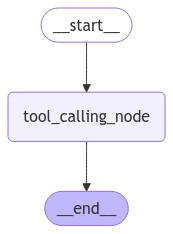

In [27]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

def tool_calling_node(state: MessagesState): 
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

builder = StateGraph(MessagesState) 
builder.add_node("tool_calling_node",tool_calling_node)
builder.add_edge(START,"tool_calling_node")
builder.add_edge("tool_calling_node",END)

workflow = builder.compile()
display(Image(workflow.get_graph().draw_mermaid_png()))

In [28]:
messages = workflow.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hi! How can I assist you today?


In [30]:
messages = workflow.invoke({"messages": HumanMessage(content="use the tools to Multiply 2 and 3!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

use the tools to Multiply 2 and 3!
================================== Ai Message ==================================
Tool Calls:
  multiply (995ba29d-8a6c-4ac8-b417-ce811dafb2dc)
 Call ID: 995ba29d-8a6c-4ac8-b417-ce811dafb2dc
  Args:
    one: 2
    two: 3
